In [4]:
import snntorch as snn
from snntorch import utils
from snntorch import spikegen
from snntorch import backprop
from snntorch import functional as SF
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

from celluloid import Camera

In [5]:
# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2) | (mnist_train.targets == 3) 
mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

print(f"The size of train_set is {len(mnist_train)}")    # 24754
print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

The size of train_set is 24754
The size of test_set is 4157


In [14]:
# Network Architecture: 100 - 200 - 4
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 

# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Input: Latency_spike X[t] and U[t-1], Neuron output: Spike S[t] and U[t]  
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=0.2)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.2)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the finial laye
        spk2_rec = []
        mem2_rec = []
        
        spike_data = spikegen.latency(x, num_steps=num_steps, threshold=0.001, clip=True, normalize=True, linear=True) 
        for latency_data in spike_data:
            cur1 = self.fc1(latency_data)          # Spike[t] x weight --> post-synaptic current
            spk1, mem1 = self.lif1(cur1, mem1)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
net = Net()

In [18]:
# pass data into the network, sum the spikes_output over time and compare the neuron with the highest number of spikes with the target
def print_batch_accuracy(data, targets, train=True):
    output, _ = net(data.reshape(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)                       # max(1):return the max value and indices of each row
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for single minibatch: {acc*100: .2f}%")
    else:
        print(f"Test set accuracy for single minibatch: {acc*100: .2f}%")
        
    return acc*100

def loss_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_loss_hist[counter]: .2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]: .2f}")
    
loss = nn.CrossEntropyLoss()   # Loss definition

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))  # Optimizer

In [19]:
# Training loop
num_epochs = 100
train_loss_hist = []
test_loss_hist = []
test_acc_hist = []

counter = 0
best_acc = 0

# Outer training loop
for epoch in range(num_epochs):
    
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:   # Or"for batch_idx, (data, targets) in enumerate(train_loader):"
        # forward pass
        net.train()      # Training mode
        spk_rec, mem_rec = net(data.reshape(batch_size, -1))   # Flatten the input data to a vector of size 100 and pass it into the network.
                                                               # output spk_rec: [10, 128, 4]
        
        # Initialize the loss and sum over time
        train_loss = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            train_loss += loss(mem_rec[step], targets)      # Cross-entropy between Pi and the target Yi([0, 1], one-hot target)
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Store train_loss history for future plotting
        train_loss_hist.append(train_loss.item())      # extract element_val and precision is higher
        
        # Test set
        with torch.no_grad():
            net.eval()          # Test mode
            test_data, test_targets = next(iter(test_loader))
            
            # Test set forward pass
            test_spk, test_mem = net(test_data.reshape(batch_size, -1))
            
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            
            test_loss_hist.append(test_loss.item())
            
            # print train/test loss/accuracy
            if counter % 10 == 0:            # iteratively print out every 10 iterations
                loss_printer()
                train_acc = print_batch_accuracy(data, targets, train=True)
                test_acc = print_batch_accuracy(test_data, test_targets, train=False)
                test_acc_hist.append(test_acc.item())
                print(test_acc)
                print("\n")
                # Store best accuracy
                if test_acc > best_acc:
                    torch.save(net.state_dict(), '10x10_Latency3.pt')
                    best_acc = test_acc
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss:  14.31
Test Set Loss:  13.88
Train set accuracy for single minibatch:  19.53%
Test set accuracy for single minibatch:  25.00%
25.0


Epoch 0, Iteration 10
Train Set Loss:  12.71
Test Set Loss:  12.89
Train set accuracy for single minibatch:  59.38%
Test set accuracy for single minibatch:  62.50%
62.5


Epoch 0, Iteration 20
Train Set Loss:  11.42
Test Set Loss:  11.38
Train set accuracy for single minibatch:  70.31%
Test set accuracy for single minibatch:  76.56%
76.5625


Epoch 0, Iteration 30
Train Set Loss:  9.66
Test Set Loss:  9.74
Train set accuracy for single minibatch:  91.41%
Test set accuracy for single minibatch:  85.16%
85.15625


Epoch 0, Iteration 40
Train Set Loss:  9.32
Test Set Loss:  8.51
Train set accuracy for single minibatch:  75.78%
Test set accuracy for single minibatch:  89.84%
89.84375


Epoch 0, Iteration 50
Train Set Loss:  7.91
Test Set Loss:  7.60
Train set accuracy for single minibatch:  89.06%
Test set accuracy for sin

Epoch 2, Iteration 94
Train Set Loss:  4.28
Test Set Loss:  4.79
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 2, Iteration 104
Train Set Loss:  4.80
Test Set Loss:  4.50
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 2, Iteration 114
Train Set Loss:  4.56
Test Set Loss:  4.22
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 2, Iteration 124
Train Set Loss:  4.99
Test Set Loss:  3.95
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 2, Iteration 134
Train Set Loss:  4.55
Test Set Loss:  4.93
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  91.41%
91.40625


Epoch 2, Iteration 144
Train Set Loss:  4.44
Test Set Loss:  3.68
Train set accuracy for single minibatch:  95.31%
Test set accuracy 

Epoch 4, Iteration 188
Train Set Loss:  3.99
Test Set Loss:  4.19
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 5, Iteration 5
Train Set Loss:  4.36
Test Set Loss:  3.93
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 5, Iteration 15
Train Set Loss:  4.81
Test Set Loss:  4.09
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 5, Iteration 25
Train Set Loss:  4.19
Test Set Loss:  4.59
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 5, Iteration 35
Train Set Loss:  4.05
Test Set Loss:  4.07
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 5, Iteration 45
Train Set Loss:  4.27
Test Set Loss:  4.76
Train set accuracy for single minibatch:  94.53%
Test set accuracy for sing

Epoch 7, Iteration 89
Train Set Loss:  4.27
Test Set Loss:  4.06
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 7, Iteration 99
Train Set Loss:  4.39
Test Set Loss:  4.06
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 7, Iteration 109
Train Set Loss:  4.89
Test Set Loss:  4.27
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 7, Iteration 119
Train Set Loss:  4.03
Test Set Loss:  4.11
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 7, Iteration 129
Train Set Loss:  3.76
Test Set Loss:  4.72
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 7, Iteration 139
Train Set Loss:  4.31
Test Set Loss:  3.40
Train set accuracy for single minibatch:  95.31%
Test set accuracy fo

Epoch 9, Iteration 183
Train Set Loss:  3.82
Test Set Loss:  3.93
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 10, Iteration 0
Train Set Loss:  3.79
Test Set Loss:  3.82
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 10, Iteration 10
Train Set Loss:  4.06
Test Set Loss:  3.93
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 10, Iteration 20
Train Set Loss:  4.21
Test Set Loss:  3.90
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 10, Iteration 30
Train Set Loss:  3.74
Test Set Loss:  3.98
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 10, Iteration 40
Train Set Loss:  5.04
Test Set Loss:  4.17
Train set accuracy for single minibatch:  93.75%
Test set accuracy fo

Epoch 12, Iteration 84
Train Set Loss:  3.70
Test Set Loss:  3.33
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 12, Iteration 94
Train Set Loss:  4.12
Test Set Loss:  4.08
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 12, Iteration 104
Train Set Loss:  4.42
Test Set Loss:  3.74
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 12, Iteration 114
Train Set Loss:  4.62
Test Set Loss:  3.68
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 12, Iteration 124
Train Set Loss:  3.78
Test Set Loss:  3.90
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 12, Iteration 134
Train Set Loss:  4.11
Test Set Loss:  3.97
Train set accuracy for single minibatch:  96.09%
Test set accura

Epoch 14, Iteration 178
Train Set Loss:  3.53
Test Set Loss:  4.11
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 14, Iteration 188
Train Set Loss:  4.29
Test Set Loss:  4.13
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 15, Iteration 5
Train Set Loss:  4.25
Test Set Loss:  3.16
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 15, Iteration 15
Train Set Loss:  3.54
Test Set Loss:  3.81
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 15, Iteration 25
Train Set Loss:  3.75
Test Set Loss:  3.71
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 15, Iteration 35
Train Set Loss:  4.59
Test Set Loss:  3.68
Train set accuracy for single minibatch:  95.31%
Test set accura

Epoch 17, Iteration 79
Train Set Loss:  4.35
Test Set Loss:  3.25
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 17, Iteration 89
Train Set Loss:  4.43
Test Set Loss:  4.47
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 17, Iteration 99
Train Set Loss:  4.44
Test Set Loss:  4.19
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 17, Iteration 109
Train Set Loss:  4.07
Test Set Loss:  4.34
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 17, Iteration 119
Train Set Loss:  3.80
Test Set Loss:  4.29
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 17, Iteration 129
Train Set Loss:  4.06
Test Set Loss:  3.99
Train set accuracy for single minibatch:  96.88%
Test set accurac

Epoch 19, Iteration 173
Train Set Loss:  4.97
Test Set Loss:  3.92
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 19, Iteration 183
Train Set Loss:  3.83
Test Set Loss:  3.87
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 20, Iteration 0
Train Set Loss:  4.02
Test Set Loss:  3.98
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 20, Iteration 10
Train Set Loss:  3.67
Test Set Loss:  3.71
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 20, Iteration 20
Train Set Loss:  4.65
Test Set Loss:  4.14
Train set accuracy for single minibatch:  91.41%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 20, Iteration 30
Train Set Loss:  4.58
Test Set Loss:  3.88
Train set accuracy for single minibatch:  95.31%
Test set accuracy fo

Epoch 22, Iteration 74
Train Set Loss:  4.10
Test Set Loss:  4.33
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 22, Iteration 84
Train Set Loss:  3.67
Test Set Loss:  3.86
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 22, Iteration 94
Train Set Loss:  3.83
Test Set Loss:  3.85
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 22, Iteration 104
Train Set Loss:  4.14
Test Set Loss:  3.99
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 22, Iteration 114
Train Set Loss:  4.30
Test Set Loss:  3.95
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  91.41%
91.40625


Epoch 22, Iteration 124
Train Set Loss:  3.93
Test Set Loss:  4.03
Train set accuracy for single minibatch:  95.31%
Test set accuracy 

Epoch 24, Iteration 168
Train Set Loss:  4.33
Test Set Loss:  3.60
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 24, Iteration 178
Train Set Loss:  3.76
Test Set Loss:  4.01
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 24, Iteration 188
Train Set Loss:  4.13
Test Set Loss:  4.34
Train set accuracy for single minibatch:  92.19%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 25, Iteration 5
Train Set Loss:  4.20
Test Set Loss:  3.69
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 25, Iteration 15
Train Set Loss:  4.69
Test Set Loss:  3.63
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 25, Iteration 25
Train Set Loss:  4.33
Test Set Loss:  4.18
Train set accuracy for single minibatch:  96.88%
Test set accuracy 

Epoch 27, Iteration 69
Train Set Loss:  3.70
Test Set Loss:  4.05
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 27, Iteration 79
Train Set Loss:  3.88
Test Set Loss:  3.71
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 27, Iteration 89
Train Set Loss:  4.75
Test Set Loss:  4.22
Train set accuracy for single minibatch:  90.62%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 27, Iteration 99
Train Set Loss:  3.91
Test Set Loss:  3.86
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 27, Iteration 109
Train Set Loss:  4.30
Test Set Loss:  3.90
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 27, Iteration 119
Train Set Loss:  4.49
Test Set Loss:  3.73
Train set accuracy for single minibatch:  95.31%
Test set accuracy fo

Epoch 29, Iteration 163
Train Set Loss:  4.14
Test Set Loss:  3.65
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 29, Iteration 173
Train Set Loss:  3.98
Test Set Loss:  3.59
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 29, Iteration 183
Train Set Loss:  4.10
Test Set Loss:  3.84
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 30, Iteration 0
Train Set Loss:  3.91
Test Set Loss:  4.18
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 30, Iteration 10
Train Set Loss:  3.82
Test Set Loss:  3.59
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 30, Iteration 20
Train Set Loss:  4.53
Test Set Loss:  3.42
Train set accuracy for single minibatch:  92.19%
Test set accuracy fo

Epoch 32, Iteration 64
Train Set Loss:  3.88
Test Set Loss:  3.87
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 32, Iteration 74
Train Set Loss:  3.69
Test Set Loss:  3.44
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 32, Iteration 84
Train Set Loss:  4.53
Test Set Loss:  3.68
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 32, Iteration 94
Train Set Loss:  4.67
Test Set Loss:  3.80
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 32, Iteration 104
Train Set Loss:  3.99
Test Set Loss:  3.65
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 32, Iteration 114
Train Set Loss:  3.79
Test Set Loss:  3.50
Train set accuracy for single minibatch:  97.66%
Test set accurac

Epoch 34, Iteration 158
Train Set Loss:  3.75
Test Set Loss:  3.76
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 34, Iteration 168
Train Set Loss:  3.65
Test Set Loss:  3.76
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 34, Iteration 178
Train Set Loss:  4.26
Test Set Loss:  3.63
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 34, Iteration 188
Train Set Loss:  3.77
Test Set Loss:  3.91
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 35, Iteration 5
Train Set Loss:  3.65
Test Set Loss:  4.11
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 35, Iteration 15
Train Set Loss:  3.55
Test Set Loss:  3.51
Train set accuracy for single minibatch:  99.22%
Test set accura

Epoch 37, Iteration 59
Train Set Loss:  3.48
Test Set Loss:  3.88
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 37, Iteration 69
Train Set Loss:  4.15
Test Set Loss:  3.78
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 37, Iteration 79
Train Set Loss:  4.02
Test Set Loss:  4.37
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 37, Iteration 89
Train Set Loss:  4.48
Test Set Loss:  3.40
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 37, Iteration 99
Train Set Loss:  4.02
Test Set Loss:  4.80
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 37, Iteration 109
Train Set Loss:  3.78
Test Set Loss:  3.44
Train set accuracy for single minibatch:  96.88%
Test set accura

Epoch 39, Iteration 153
Train Set Loss:  3.82
Test Set Loss:  4.18
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 39, Iteration 163
Train Set Loss:  3.92
Test Set Loss:  3.50
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 39, Iteration 173
Train Set Loss:  3.31
Test Set Loss:  3.63
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 39, Iteration 183
Train Set Loss:  3.88
Test Set Loss:  3.74
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 40, Iteration 0
Train Set Loss:  3.74
Test Set Loss:  3.20
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 40, Iteration 10
Train Set Loss:  4.01
Test Set Loss:  4.25
Train set accuracy for single minibatch:  96.88%
Test set accur

Epoch 42, Iteration 54
Train Set Loss:  4.01
Test Set Loss:  3.66
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 42, Iteration 64
Train Set Loss:  4.12
Test Set Loss:  3.64
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 42, Iteration 74
Train Set Loss:  3.89
Test Set Loss:  3.71
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 42, Iteration 84
Train Set Loss:  4.23
Test Set Loss:  4.86
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 42, Iteration 94
Train Set Loss:  4.12
Test Set Loss:  4.51
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 42, Iteration 104
Train Set Loss:  4.45
Test Set Loss:  4.12
Train set accuracy for single minibatch:  96.09%
Test set accuracy f

Epoch 44, Iteration 148
Train Set Loss:  3.99
Test Set Loss:  4.00
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 44, Iteration 158
Train Set Loss:  4.18
Test Set Loss:  3.79
Train set accuracy for single minibatch:  92.19%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 44, Iteration 168
Train Set Loss:  3.80
Test Set Loss:  3.75
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 44, Iteration 178
Train Set Loss:  3.88
Test Set Loss:  3.77
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 44, Iteration 188
Train Set Loss:  3.78
Test Set Loss:  4.31
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 45, Iteration 5
Train Set Loss:  3.62
Test Set Loss:  4.24
Train set accuracy for single minibatch:  95.31%
Test set accura

Epoch 47, Iteration 49
Train Set Loss:  4.01
Test Set Loss:  3.64
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 47, Iteration 59
Train Set Loss:  4.14
Test Set Loss:  3.42
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 47, Iteration 69
Train Set Loss:  3.89
Test Set Loss:  3.78
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 47, Iteration 79
Train Set Loss:  4.18
Test Set Loss:  3.42
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 47, Iteration 89
Train Set Loss:  3.75
Test Set Loss:  3.86
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 47, Iteration 99
Train Set Loss:  3.59
Test Set Loss:  2.97
Train set accuracy for single minibatch:  96.09%
Test set accuracy

Epoch 49, Iteration 143
Train Set Loss:  3.74
Test Set Loss:  3.81
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 49, Iteration 153
Train Set Loss:  4.05
Test Set Loss:  4.33
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 49, Iteration 163
Train Set Loss:  3.60
Test Set Loss:  3.65
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 49, Iteration 173
Train Set Loss:  3.24
Test Set Loss:  4.14
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 49, Iteration 183
Train Set Loss:  4.67
Test Set Loss:  3.70
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 50, Iteration 0
Train Set Loss:  4.31
Test Set Loss:  3.35
Train set accuracy for single minibatch:  96.09%
Test set accur

Epoch 52, Iteration 44
Train Set Loss:  3.80
Test Set Loss:  3.85
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 52, Iteration 54
Train Set Loss:  3.89
Test Set Loss:  3.55
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 52, Iteration 64
Train Set Loss:  3.96
Test Set Loss:  3.20
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 52, Iteration 74
Train Set Loss:  3.72
Test Set Loss:  3.74
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 52, Iteration 84
Train Set Loss:  3.77
Test Set Loss:  3.95
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 52, Iteration 94
Train Set Loss:  3.97
Test Set Loss:  3.65
Train set accuracy for single minibatch:  94.53%
Test set accura

Epoch 54, Iteration 138
Train Set Loss:  4.38
Test Set Loss:  3.54
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 54, Iteration 148
Train Set Loss:  4.16
Test Set Loss:  3.70
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 54, Iteration 158
Train Set Loss:  3.97
Test Set Loss:  4.14
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 54, Iteration 168
Train Set Loss:  3.60
Test Set Loss:  4.16
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 54, Iteration 178
Train Set Loss:  3.81
Test Set Loss:  3.50
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 54, Iteration 188
Train Set Loss:  4.35
Test Set Loss:  3.79
Train set accuracy for single minibatch:  95.31%
Test set acc

Epoch 57, Iteration 39
Train Set Loss:  4.14
Test Set Loss:  3.78
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 57, Iteration 49
Train Set Loss:  3.53
Test Set Loss:  3.63
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 57, Iteration 59
Train Set Loss:  4.31
Test Set Loss:  3.73
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 57, Iteration 69
Train Set Loss:  3.75
Test Set Loss:  3.69
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 57, Iteration 79
Train Set Loss:  4.33
Test Set Loss:  3.51
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 57, Iteration 89
Train Set Loss:  4.27
Test Set Loss:  3.30
Train set accuracy for single minibatch:  92.97%
Test set accuracy

Epoch 59, Iteration 133
Train Set Loss:  3.94
Test Set Loss:  4.04
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 59, Iteration 143
Train Set Loss:  3.72
Test Set Loss:  4.21
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 59, Iteration 153
Train Set Loss:  3.42
Test Set Loss:  3.71
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 59, Iteration 163
Train Set Loss:  3.88
Test Set Loss:  3.41
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 59, Iteration 173
Train Set Loss:  3.97
Test Set Loss:  4.14
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 59, Iteration 183
Train Set Loss:  3.93
Test Set Loss:  3.39
Train set accuracy for single minibatch:  96.09%
Test set accuracy

Epoch 62, Iteration 34
Train Set Loss:  3.65
Test Set Loss:  3.48
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 62, Iteration 44
Train Set Loss:  3.63
Test Set Loss:  3.57
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 62, Iteration 54
Train Set Loss:  3.57
Test Set Loss:  3.98
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 62, Iteration 64
Train Set Loss:  3.74
Test Set Loss:  3.87
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 62, Iteration 74
Train Set Loss:  4.24
Test Set Loss:  3.35
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 62, Iteration 84
Train Set Loss:  4.21
Test Set Loss:  3.84
Train set accuracy for single minibatch:  94.53%
Test set accurac

Epoch 64, Iteration 128
Train Set Loss:  3.32
Test Set Loss:  3.36
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 64, Iteration 138
Train Set Loss:  3.99
Test Set Loss:  4.14
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 64, Iteration 148
Train Set Loss:  3.38
Test Set Loss:  3.34
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 64, Iteration 158
Train Set Loss:  3.82
Test Set Loss:  3.71
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 64, Iteration 168
Train Set Loss:  3.86
Test Set Loss:  3.67
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 64, Iteration 178
Train Set Loss:  3.93
Test Set Loss:  4.13
Train set accuracy for single minibatch:  96.09%
Test set accu

Epoch 67, Iteration 29
Train Set Loss:  3.59
Test Set Loss:  3.87
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 67, Iteration 39
Train Set Loss:  3.78
Test Set Loss:  3.90
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 67, Iteration 49
Train Set Loss:  3.58
Test Set Loss:  3.89
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 67, Iteration 59
Train Set Loss:  3.61
Test Set Loss:  3.57
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 67, Iteration 69
Train Set Loss:  3.84
Test Set Loss:  4.32
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  91.41%
91.40625


Epoch 67, Iteration 79
Train Set Loss:  3.68
Test Set Loss:  4.40
Train set accuracy for single minibatch:  97.66%
Test set accurac

Epoch 69, Iteration 123
Train Set Loss:  3.90
Test Set Loss:  3.69
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 69, Iteration 133
Train Set Loss:  3.87
Test Set Loss:  4.92
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 69, Iteration 143
Train Set Loss:  3.99
Test Set Loss:  3.64
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 69, Iteration 153
Train Set Loss:  3.64
Test Set Loss:  3.68
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 69, Iteration 163
Train Set Loss:  3.84
Test Set Loss:  3.69
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 69, Iteration 173
Train Set Loss:  3.62
Test Set Loss:  3.81
Train set accuracy for single minibatch:  96.88%
Test set accur

Epoch 72, Iteration 24
Train Set Loss:  3.76
Test Set Loss:  3.11
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 72, Iteration 34
Train Set Loss:  3.79
Test Set Loss:  4.02
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 72, Iteration 44
Train Set Loss:  4.25
Test Set Loss:  3.48
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 72, Iteration 54
Train Set Loss:  4.44
Test Set Loss:  3.91
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 72, Iteration 64
Train Set Loss:  3.96
Test Set Loss:  4.50
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  92.19%
92.1875


Epoch 72, Iteration 74
Train Set Loss:  3.14
Test Set Loss:  3.80
Train set accuracy for single minibatch:  99.22%
Test set accuracy 

Epoch 74, Iteration 118
Train Set Loss:  3.44
Test Set Loss:  3.72
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 74, Iteration 128
Train Set Loss:  3.92
Test Set Loss:  3.58
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 74, Iteration 138
Train Set Loss:  4.18
Test Set Loss:  4.29
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 74, Iteration 148
Train Set Loss:  4.06
Test Set Loss:  4.17
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 74, Iteration 158
Train Set Loss:  3.65
Test Set Loss:  4.65
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 74, Iteration 168
Train Set Loss:  3.67
Test Set Loss:  3.76
Train set accuracy for single minibatch:  96.09%
Test set accura

Epoch 77, Iteration 19
Train Set Loss:  4.13
Test Set Loss:  3.50
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 77, Iteration 29
Train Set Loss:  3.76
Test Set Loss:  3.67
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 77, Iteration 39
Train Set Loss:  3.71
Test Set Loss:  3.17
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 77, Iteration 49
Train Set Loss:  3.88
Test Set Loss:  4.20
Train set accuracy for single minibatch:  92.19%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 77, Iteration 59
Train Set Loss:  3.96
Test Set Loss:  3.60
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 77, Iteration 69
Train Set Loss:  4.40
Test Set Loss:  3.44
Train set accuracy for single minibatch:  95.31%
Test set accuracy

Epoch 79, Iteration 113
Train Set Loss:  3.82
Test Set Loss:  3.33
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  99.22%
99.21875


Epoch 79, Iteration 123
Train Set Loss:  3.96
Test Set Loss:  4.54
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 79, Iteration 133
Train Set Loss:  4.09
Test Set Loss:  4.04
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 79, Iteration 143
Train Set Loss:  3.95
Test Set Loss:  3.59
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 79, Iteration 153
Train Set Loss:  4.15
Test Set Loss:  3.93
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 79, Iteration 163
Train Set Loss:  3.91
Test Set Loss:  4.01
Train set accuracy for single minibatch:  96.88%
Test set accurac

Epoch 82, Iteration 14
Train Set Loss:  4.00
Test Set Loss:  4.25
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 82, Iteration 24
Train Set Loss:  4.29
Test Set Loss:  3.55
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 82, Iteration 34
Train Set Loss:  4.55
Test Set Loss:  4.28
Train set accuracy for single minibatch:  92.19%
Test set accuracy for single minibatch:  93.75%
93.75


Epoch 82, Iteration 44
Train Set Loss:  3.96
Test Set Loss:  4.22
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 82, Iteration 54
Train Set Loss:  3.50
Test Set Loss:  4.24
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 82, Iteration 64
Train Set Loss:  3.94
Test Set Loss:  3.81
Train set accuracy for single minibatch:  94.53%
Test set accuracy fo

Epoch 84, Iteration 108
Train Set Loss:  3.78
Test Set Loss:  3.95
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 84, Iteration 118
Train Set Loss:  3.60
Test Set Loss:  3.90
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 84, Iteration 128
Train Set Loss:  3.77
Test Set Loss:  4.20
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  91.41%
91.40625


Epoch 84, Iteration 138
Train Set Loss:  3.89
Test Set Loss:  3.28
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  100.00%
100.0


Epoch 84, Iteration 148
Train Set Loss:  3.66
Test Set Loss:  4.18
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 84, Iteration 158
Train Set Loss:  3.76
Test Set Loss:  4.01
Train set accuracy for single minibatch:  96.09%
Test set ac

Epoch 87, Iteration 9
Train Set Loss:  3.41
Test Set Loss:  3.68
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 87, Iteration 19
Train Set Loss:  4.18
Test Set Loss:  4.59
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 87, Iteration 29
Train Set Loss:  3.80
Test Set Loss:  3.39
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 87, Iteration 39
Train Set Loss:  3.89
Test Set Loss:  3.74
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 87, Iteration 49
Train Set Loss:  3.72
Test Set Loss:  3.99
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 87, Iteration 59
Train Set Loss:  3.68
Test Set Loss:  3.65
Train set accuracy for single minibatch:  96.09%
Test set accuracy for s

Epoch 89, Iteration 103
Train Set Loss:  4.07
Test Set Loss:  3.56
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 89, Iteration 113
Train Set Loss:  3.88
Test Set Loss:  3.91
Train set accuracy for single minibatch:  98.44%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 89, Iteration 123
Train Set Loss:  4.49
Test Set Loss:  3.79
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 89, Iteration 133
Train Set Loss:  4.21
Test Set Loss:  3.57
Train set accuracy for single minibatch:  90.62%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 89, Iteration 143
Train Set Loss:  3.62
Test Set Loss:  3.63
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 89, Iteration 153
Train Set Loss:  3.82
Test Set Loss:  3.32
Train set accuracy for single minibatch:  96.09%
Test set accura

Epoch 92, Iteration 4
Train Set Loss:  3.81
Test Set Loss:  3.66
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 92, Iteration 14
Train Set Loss:  4.84
Test Set Loss:  4.07
Train set accuracy for single minibatch:  92.19%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 92, Iteration 24
Train Set Loss:  3.47
Test Set Loss:  3.56
Train set accuracy for single minibatch:  93.75%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 92, Iteration 34
Train Set Loss:  3.96
Test Set Loss:  3.89
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 92, Iteration 44
Train Set Loss:  3.56
Test Set Loss:  4.06
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 92, Iteration 54
Train Set Loss:  4.53
Test Set Loss:  3.77
Train set accuracy for single minibatch:  96.88%
Test set accuracy for

Epoch 94, Iteration 98
Train Set Loss:  3.61
Test Set Loss:  3.99
Train set accuracy for single minibatch:  97.66%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 94, Iteration 108
Train Set Loss:  4.01
Test Set Loss:  3.57
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 94, Iteration 118
Train Set Loss:  4.09
Test Set Loss:  3.97
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 94, Iteration 128
Train Set Loss:  4.45
Test Set Loss:  3.82
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 94, Iteration 138
Train Set Loss:  4.19
Test Set Loss:  4.09
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.09%
96.09375


Epoch 94, Iteration 148
Train Set Loss:  3.32
Test Set Loss:  3.86
Train set accuracy for single minibatch:  99.22%
Test set accur

Epoch 96, Iteration 192
Train Set Loss:  3.71
Test Set Loss:  4.31
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  92.97%
92.96875


Epoch 97, Iteration 9
Train Set Loss:  4.41
Test Set Loss:  3.90
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 97, Iteration 19
Train Set Loss:  3.84
Test Set Loss:  4.27
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  97.66%
97.65625


Epoch 97, Iteration 29
Train Set Loss:  3.72
Test Set Loss:  3.62
Train set accuracy for single minibatch:  99.22%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 97, Iteration 39
Train Set Loss:  4.09
Test Set Loss:  3.58
Train set accuracy for single minibatch:  92.97%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 97, Iteration 49
Train Set Loss:  4.16
Test Set Loss:  3.72
Train set accuracy for single minibatch:  94.53%
Test set accuracy

Epoch 99, Iteration 93
Train Set Loss:  4.02
Test Set Loss:  3.97
Train set accuracy for single minibatch:  95.31%
Test set accuracy for single minibatch:  94.53%
94.53125


Epoch 99, Iteration 103
Train Set Loss:  4.40
Test Set Loss:  3.75
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  98.44%
98.4375


Epoch 99, Iteration 113
Train Set Loss:  3.65
Test Set Loss:  3.74
Train set accuracy for single minibatch:  96.88%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 99, Iteration 123
Train Set Loss:  3.77
Test Set Loss:  4.00
Train set accuracy for single minibatch:  96.09%
Test set accuracy for single minibatch:  95.31%
95.3125


Epoch 99, Iteration 133
Train Set Loss:  4.13
Test Set Loss:  3.87
Train set accuracy for single minibatch:  94.53%
Test set accuracy for single minibatch:  96.88%
96.875


Epoch 99, Iteration 143
Train Set Loss:  4.25
Test Set Loss:  4.53
Train set accuracy for single minibatch:  96.09%
Test set accurac

In [20]:
print(best_acc)

100.0


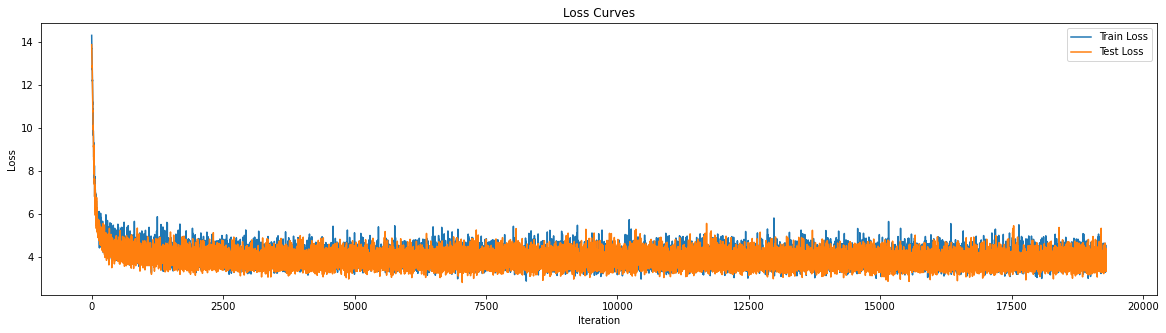

In [21]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

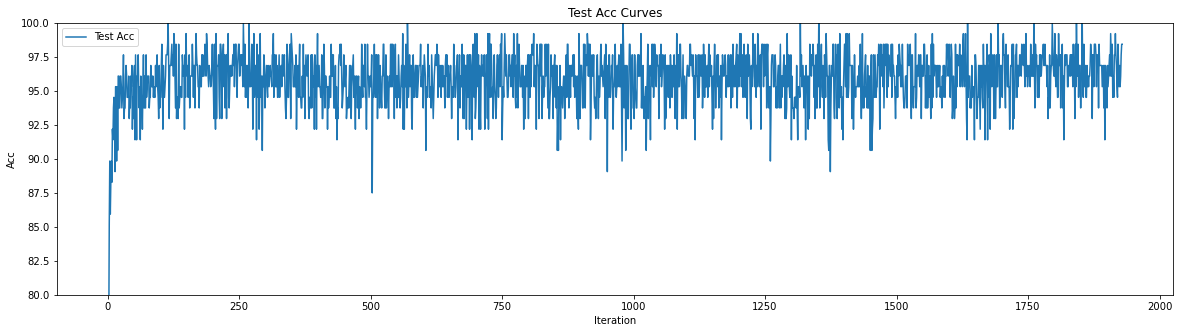

In [22]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.plot(test_acc_hist)
plt.title("Test Acc Curves")
plt.legend(["Test Acc"])
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.ylim((80, 100))
plt.show()

In [23]:
print(test_acc_hist)

[25.0, 62.5, 76.5625, 85.15625, 89.84375, 85.9375, 88.28125, 89.84375, 88.28125, 92.1875, 91.40625, 93.75, 94.53125, 92.96875, 89.0625, 95.3125, 95.3125, 89.84375, 95.3125, 90.625, 96.09375, 96.09375, 93.75, 93.75, 96.09375, 96.09375, 95.3125, 93.75, 94.53125, 95.3125, 97.65625, 92.96875, 93.75, 93.75, 96.09375, 96.875, 96.09375, 94.53125, 94.53125, 94.53125, 96.09375, 92.96875, 94.53125, 93.75, 96.09375, 95.3125, 96.875, 92.1875, 94.53125, 92.96875, 96.09375, 96.875, 91.40625, 97.65625, 94.53125, 91.40625, 96.09375, 96.09375, 97.65625, 95.3125, 93.75, 95.3125, 91.40625, 96.09375, 94.53125, 94.53125, 92.1875, 95.3125, 97.65625, 93.75, 96.09375, 93.75, 93.75, 97.65625, 94.53125, 95.3125, 96.09375, 96.09375, 96.09375, 93.75, 94.53125, 94.53125, 96.875, 95.3125, 96.09375, 95.3125, 96.09375, 94.53125, 95.3125, 94.53125, 94.53125, 96.875, 95.3125, 96.875, 97.65625, 95.3125, 94.53125, 92.96875, 96.875, 93.75, 94.53125, 94.53125, 96.875, 98.4375, 95.3125, 92.1875, 96.875, 94.53125, 94.53125, 